### Feature Matching 

####  A problem commonly observed across different GAN models is a situation where the generator fixes on producing a limited set of predictions which may be great for “beating” the discriminator for a short duration but this only forces the discriminator to optimize towards just rejecting all images made by the generator, perpetuating an eternal back and forth. This phenomenon is formally known as mode collapse. A means to mitigate this, is to alter the loss strategy from minimizing the predictions to the label to minimizing the predictions to the outputs of an intermediate layer of the discriminator when “fed” real images of. The assumption  here is that the activations of the intermediate layer will progress toward a statistically significant set of activations for a specific target(real frog images), of which can be leveraged to improve the robustness of the generators predictions.  

https://towardsdatascience.com/gan-ways-to-improve-gan-performance-acf37f9f59b

https://developers.google.com/machine-learning/gan/problems

https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=2&cad=rja&uact=8&ved=2ahUKEwi1hOjRovPoAhVnFTQIHUpKA0QQFjABegQIBBAB&url=https%3A%2F%2Farxiv.org%2Fpdf%2F1702.08398&usg=AOvVaw1gyCjLHiGxphLC_nm8i9OU

In [1]:
import keras
keras.__version__
import keras
from keras import layers, Model
from keras.engine.topology import Layer
import keras.backend as K
import numpy as np


Using TensorFlow backend.


#### a global variable used a placeholder to statisfy the loss defintion

In [2]:
batch_size = 1
global dis_intermediate_output
dis_intermediate_output = np.zeros((32,32,3))

### The Generator

#### The main modification here is the use of the custom loss function which takes a layer in and computes a loss between it and the global dis_intermediate_output, and making the last layer distinguishable in order be able to pass it into the custom loss function.

In [4]:
import keras
from keras import layers



latent_dim = 32
height = 32
width = 32
channels = 3

generator_input = keras.Input(shape=(latent_dim,))

# First, transform the input into a 16x16 128-channels feature map
x = layers.Dense(128 * 16 * 16)(generator_input)
x = layers.LeakyReLU()(x)
x = layers.Reshape((16, 16, 128))(x)

# Then, add a convolution layer
x = layers.Conv2D(256, 5, padding='same')(x)
y = layers.LeakyReLU()(x)

# Upsample to 32x32
x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(y)
x = layers.LeakyReLU()(x)

# Few more conv layers
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
out = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)


# Define custom loss
def custom_loss(layer):

    # Create a loss function that adds the MSE loss to the mean of all squared activations of a specific layer
    def custom_loss(y_true,y_pred):
        #print(y_pred.shape)
        #print(dis_intermediate_output.shape)
        return keras.losses.mse(y_pred,dis_intermediate_output)
   
    # Return a function
    return custom_loss
# Produce a 32x32 1-channel feature map
generator = keras.models.Model(generator_input,out)


#### A quick printout of what images made by the untrained generator model.

(2, 32)
(2, 32, 32, 3)


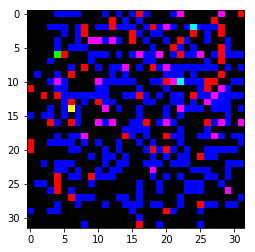

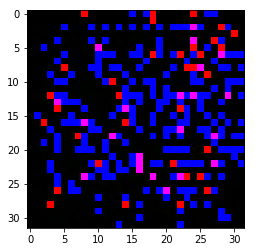

In [6]:
%matplotlib inline
from keras.preprocessing import image
import matplotlib.pyplot as plt

random_latent_vectors = np.random.normal(size=(2, latent_dim))
print(random_latent_vectors.shape)
# Decode them to fake images
generated_images = generator.predict(random_latent_vectors)
print(generated_images.shape)
for i in range(generated_images.shape[0]):
    img = image.array_to_img(generated_images[i] * 255., scale=False)
    plt.figure()
    plt.imshow(img)
    
plt.show()

## The discriminator


The only modification here is decreasing the learning by a few folds, in order to prevent overfiiting.

In [7]:
discriminator_input = layers.Input(shape=(height, width, channels))
#x = layers.Dense(3,)(discriminator_input)#Add layer as a looking glass for feature extraction
x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)

# One dropout layer - important trick!
x = layers.Dropout(0.4)(x)

# Classification layer
x = layers.Dense(1, activation='sigmoid')(x)

discriminator = keras.models.Model(discriminator_input, x)
discriminator.summary()

# To stabilize training, we use learning rate decay
# and gradient clipping (by value) in the optimizer.
discriminator_optimizer = keras.optimizers.RMSprop(lr=0.00004, clipvalue=1.0, decay=1e-8)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')
dis_copy= keras.models.clone_model(discriminator)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 30, 128)       3584      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 6, 6, 128)         262272    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 6, 6, 128)         0   

## The adversarial network

Similar to the discriminator, we decrease the learning rate to match it.  We also introduce our custom loss function  and pass in the generators output layer.

In [8]:
# Set discriminator weights to non-trainable
# (will only apply to the `gan` model)
discriminator.trainable = False

gan_input = keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)

gan_optimizer = keras.optimizers.RMSprop(lr=0.00004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss=custom_loss(generator.layers[12]))

## Training

Unlike the Cholliet’s implementation, we introduce the means to collect the activations of the chosen layer. The team had to determine the best layer for the task. At first it was believed that the earliest layers would represent something closest to the input tensor, this was not the case. The earlier layers seem to focus the color gradient from the outside of the image towards the middle(i.e. Green to brown), whereas later models appeared to be laser focused on a very specific artifact of frog images like an elbow or set of eyes. Layer 6 in our case seem to be looking for the general shape of a frog which made it perfect for the job. 

In [10]:
import os
from keras.preprocessing import image

# Load CIFAR10 data
(x_train, y_train), (_, _) = keras.datasets.cifar10.load_data()

# Select frog images (class 6)
x_train = x_train[y_train.flatten() == 6]

# Normalize data
x_train = x_train.reshape(
    (x_train.shape[0],) + (height, width, channels)).astype('float32') / 255.

iterations = 10000
gif_ary = []
save_dir = 'C:\\Users\\juan\\PycharmProjects\\dCholliet\\deep-learning-with-python-notebooks\\gan_images'

# Start training loop
start = 0
for step in range(iterations):
    # Sample random points in the latent space
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    # Decode them to fake images
    generated_images = generator.predict(random_latent_vectors)

    # Combine them with real images
    stop = start + batch_size
    real_images = x_train[start: stop]
    
    #############Get activations of real images or generator loss function################################################
    layer_name = dis_copy.layers[6].name #Desired layer
    #get activations of intermediate layer from just real images without tainting GAN model
    intermediate_layer_model = Model(inputs=dis_copy.input,
                             outputs=dis_copy.get_layer(layer_name).output)
    dis_intermediate_output = intermediate_layer_model.predict_on_batch(real_images)
    #print("activation means: " +str(np.mean(dis_intermediate_output)))

    ####################################################################################
    combined_images = np.concatenate([generated_images, real_images])

    # Assemble labels discriminating real from fake images
    labels = np.concatenate([np.ones((batch_size, 1)),
                             np.zeros((batch_size, 1))])
    # Add random noise to the labels - important trick!
    labels += 0.05 * np.random.random(labels.shape)

    # Train the discriminator
    d_loss = discriminator.train_on_batch(combined_images, labels)

    # sample random points in the latent space
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    # Assemble labels that say "all real images"
    misleading_targets = np.zeros((batch_size, 1))

    # Train the generator (via the gan model,
    # where the discriminator weights are frozen)
    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)
    
    start += batch_size
    if start > len(x_train) - batch_size:
        start = 0
    
    # Occasionally save / plot
    if step % 100 == 0:
        # Save model weights
        gan.save_weights('gan.h5')

        # Print metrics
        print('discriminator loss at step %s: %s' % (step, d_loss))
        print('adversarial loss at step %s: %s' % (step, a_loss))

        # Save one generated image
        img = image.array_to_img(generated_images[0] * 255., scale=False)
        gif_ary.append(img.resize((256,256),1))
        img.save(os.path.join(save_dir, 'generated_frog' + str(step) + '.png'))

        # Save one real image, for comparison
        img = image.array_to_img(real_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'real_frog' + str(step) + '.png'))
 


c:\users\juan\anaconda3\envs\py35\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


discriminator loss at step 0: 0.6862771
adversarial loss at step 0: 0.2497258


c:\users\juan\anaconda3\envs\py35\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


discriminator loss at step 100: 0.6707721
adversarial loss at step 100: 0.27350262
discriminator loss at step 200: 0.6916306
adversarial loss at step 200: 0.24854447
discriminator loss at step 300: 0.70674044
adversarial loss at step 300: 0.25452062
discriminator loss at step 400: 0.66287374
adversarial loss at step 400: 0.27664253
discriminator loss at step 500: 0.7062178
adversarial loss at step 500: 0.26390037
discriminator loss at step 600: 0.6630109
adversarial loss at step 600: 0.27592385
discriminator loss at step 700: 0.6788885
adversarial loss at step 700: 0.26242137
discriminator loss at step 800: 0.6877109
adversarial loss at step 800: 0.28583166
discriminator loss at step 900: 0.68327403
adversarial loss at step 900: 0.2546502
discriminator loss at step 1000: 0.7275764
adversarial loss at step 1000: 0.25554493
discriminator loss at step 1100: 0.668346
adversarial loss at step 1100: 0.30364934
discriminator loss at step 1200: 0.7045038
adversarial loss at step 1200: 0.257287

discriminator loss at step 9800: 0.68608993
adversarial loss at step 9800: 0.25461128
discriminator loss at step 9900: 0.6808994
adversarial loss at step 9900: 0.25544548


In [15]:
gif_ary[0].save('pr3ds.gif',
               save_all=True, append_images=gif_ary[1:], optimize=False, duration=500, loop=0)

Let's display a few of our fake images:

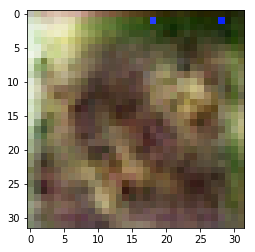

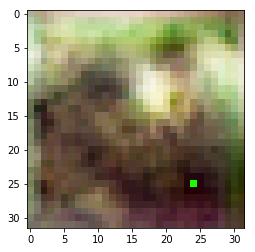

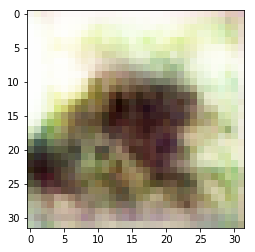

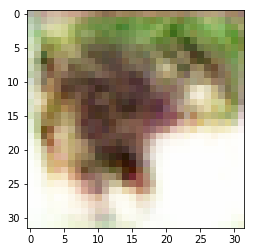

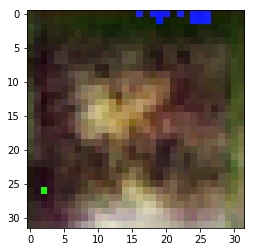

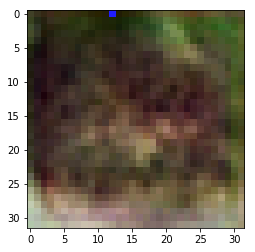

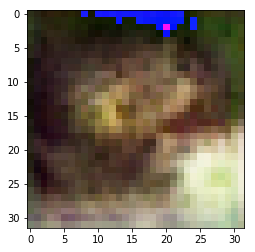

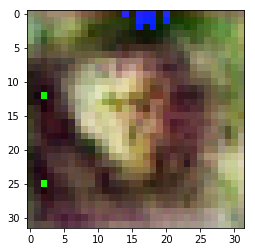

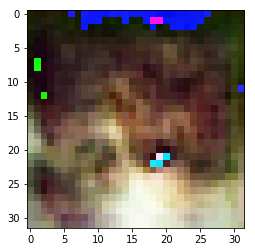

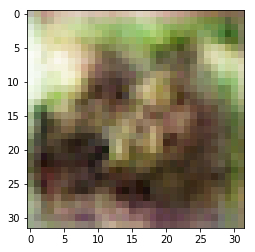

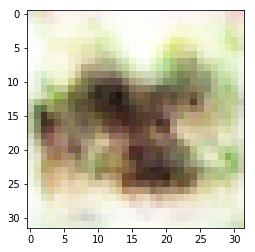

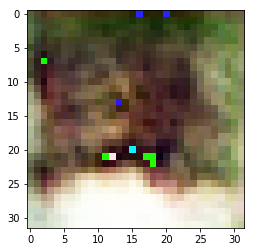

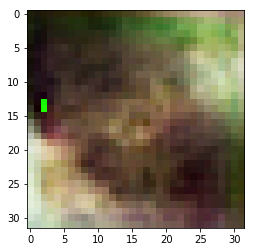

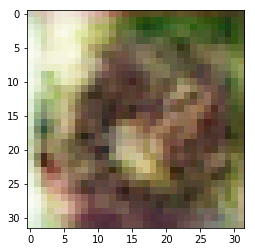

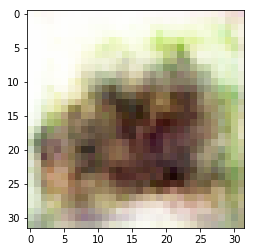

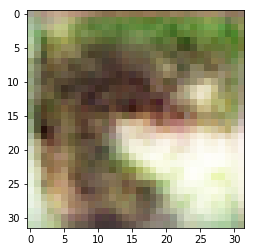

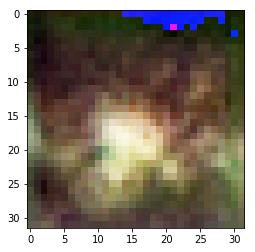

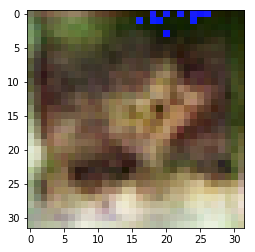

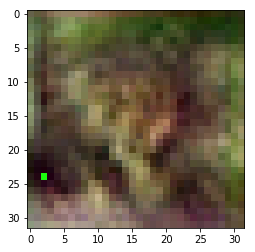

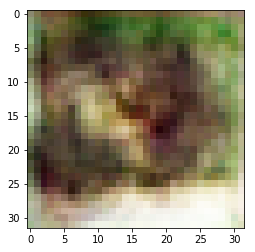

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt


# Sample random points in the latent space
random_latent_vectors = np.random.normal(size=(20, latent_dim))

# Decode them to fake images
generated_images = generator.predict(random_latent_vectors)

for i in range(generated_images.shape[0]):
    img = image.array_to_img(generated_images[i] * 255., scale=False)
    plt.figure()
    plt.imshow(img)
    
plt.show()

Froggy with some pixellated artifacts.

### Discussion 

Looking at the metrics alone, it looks like we’ve improved our results for both the discriminator and the generator, as well as converging significantly faster. In terms of the images generator, it is tough to say if we achieved the desired result of not allowing the optimization to fixate on one type of image. It does appear, based on the images outputted, the shape of a frog appears to be in a wide array of orientations, as well of different, yet expected color gradients one might find in images of frogs. Based on the progression of images generated during the training process, one might speculate the goal was achieved as a general trend of images emerges but the model still produces blue and yellow color gradients in later stages of the training process , indicating that the generator is being forced to perturb its “best” strategy for fooling the discriminator and thereby passing on that richness onto it. 

#### Progression of generator predictions during training:

![frogUrl](https://media.giphy.com/media/gfU9PrAlTIixxsKcIa/giphy.gif "Progression")
